# Saxena Standard State Code Generator 
Required system packages and initialization

In [1]:
import pandas as pd
import numpy as np
import sympy as sym
sym.init_printing()

Required ENKI packages

In [2]:
from thermoengine import coder

# Types of terms in a standard state properties description
There are three classes of terms:
1. Terms that apply over the whole of $T$-, $P$-space, $T_r \le T$, $P_r \le P$
2. Terms that apply over a specified range of $T$-, $P$-space, $(T_{r_\lambda},P_{r_\lambda}) \le (T,P) \le (T_\lambda,P_\lambda)$
3. Terms that apply to a specific $T_t$ and $P_t$ and higher $T$, $P$, $T_t \le T$, $P_t \le P$

Second-order phase transitions ($lambda$-transitions) are an example of the second type, as are order disorder transformations. First-order phase transitions are an example of the third type.  

## Create a model class for the Gibbs free energy

In [3]:
model = coder.StdStateModel()

Retrieve sympy symbols for model variables and reference conditions

In [4]:
T = model.get_symbol_for_t()
P = model.get_symbol_for_p()
Tr = model.get_symbol_for_tr()
Pr = model.get_symbol_for_pr()

### Define model expressions applicable over all of T,P space
An expression for the Gibbs free energy, $G(T,P)$ or the Helmholtz energy $A(T,V)$ is constructed.  The expression may have multiple parts.  Often the heat capacity function is postulated, then integrated to yield expressions for the entahlpy, entropy, and in combination the energy potential. Then, an equation of state (EOS) is adopted and that term is integrated in pressure or volume and added to the heat capacity integrals. This proceedure is follwed here.
#### (1) $C_P$ integrals
The isobaric heat capacity terms parameterized as: $C_P = a_{C_P} + b_{C_P} T + c_{C_P}/T^2 + d_{C_P} T^2 + e_{C_P}/T^3 + g_{C_P}/\sqrt{T} + h_{C_P}/T$,


and in addition the reference condition third law entropy, $ S_{Tr,Pr} $, and enthalpy of formation from the
elements, $ \Delta H_{Tr,Pr} $, constitute additional parameters:

In [5]:
acp,bcp,ccp,dcp,ecp,gcp,hcp = sym.symbols('a_cp b_cp c_cp d_cp e_cp g_cp h_cp')
CpPr = acp + bcp*T + ccp/T**2 + dcp*T**2 + ecp/T**3 + gcp/sym.sqrt(T) + hcp/T
STrPr,HTrPr = sym.symbols('S_TrPr H_TrPr')

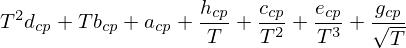

In [6]:
CpPr

Specify paramters ...

In [7]:
params = [('H_TrPr','J',HTrPr), ('S_TrPr','J/K',STrPr), 
          ('a_cp','J/K-m',acp), 
          ('b_cp','J/K^2-m',bcp), 
          ('c_cp','J*K/m',ccp), 
          ('d_cp','J/K^3-m',dcp), 
          ('e_cp','J*K^2/m',ecp), 
          ('g_cp','J/K^{1/2}-m',gcp),
          ('h_cp','J/m',hcp)]

Define the heat capacity contribution to the Gibbs free energy ...

In [8]:
GPr = HTrPr + sym.integrate(CpPr,(T,Tr,T)) - T*(STrPr + sym.integrate(CpPr/T,(T,Tr,T)))

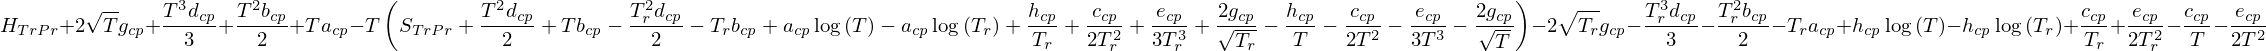

In [9]:
GPr

... and add this expression to the model

In [10]:
model.add_expression_to_model(GPr, params)

#### (2) $V$ (EOS) integrals
Next, define a volume-explicit equation of state applicable over the whole of temperature and pressure space


In [11]:
VTrPr,a0,K0 = sym.symbols('V_TrPr a0 K0')

V_T, K_T, dK_T, dK_P = sym.symbols("V_T K_T K'_T K'_P")

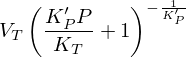

In [13]:
V = V_T*(1+dK_P*P/K_T)**(-1/dK_P)
V

#### (2) $V$ (EOS) integrals
Next, define a volume-implicit equation of state applicable over the whole of temperature and pressure space.  We will use the 3rd order Birch-Murnaghan expression:  
$P = \frac{{3K}}{2}\left[ {{{\left( {\frac{{{V_{{T_r}.{P_r}}}}}{V}} \right)}^{\frac{7}{3}}} - {{\left( {\frac{{{V_{{T_r}.{P_r}}}}}{V}} \right)}^{\frac{5}{3}}}} \right]\left\{ {\left( {\frac{{3{K_P}}}{4} - 3} \right)\left[ {{{\left( {\frac{{{V_{{T_r}.{P_r}}}}}{V}} \right)}^{\frac{2}{3}}} - 1} \right] + 1} \right\}$  
The parameters in this expression are:

In [11]:
VTrPr,K,Kp, alpha = sym.symbols('V_TrPr K K_P alpha')
params = [('V_TrPr', 'J/bar-m', VTrPr), ('K','bar',K), ('K_P','',Kp), 
          ('alpha','1/K',alpha)]

where *V* is an implicit function of *T* and *P*:

In [12]:
V = sym.Function('V')(T,P)

Define *f*, an implicit function derived from the Birch-Murnaghan expression. *f* has a value zero for internally consistent *V*, *T*, and *P*:  
$f = 0 = \frac{{3K}}{2}\left[ {{{\left( {\frac{{{V_{{T_r}.{P_r}}}}}{V}} \right)}^{\frac{7}{3}}} - {{\left( {\frac{{{V_{{T_r}.{P_r}}}}}{V}} \right)}^{\frac{5}{3}}}} \right]\left\{ {\left( {\frac{{3{K_P}}}{4} - 3} \right)\left[ {{{\left( {\frac{{{V_{{T_r}.{P_r}}}}}{V}} \right)}^{\frac{2}{3}}} - 1} \right] + 1} \right\} - P$

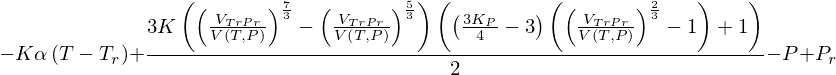

In [17]:
f = (sym.S(3)*K/sym.S(2))*(
    (VTrPr/V)**(sym.S(7)/sym.S(3))-(VTrPr/V)**(sym.S(5)/sym.S(3)))*(
    1+(sym.S(3)/sym.S(4))*(Kp-4)*((VTrPr/V)**(sym.S(2)/sym.S(3))-1)) -(
    alpha*K*(T-Tr)) + Pr - P 
f

Because the EOS is explicit in *P* (and a function of *T* and *V*), the natural thermodynamic potential to use is the Helmholtz energy, *A*. *A* is obtained by integrating pressure from the reference volume to the final volume:  
${A_{T,P}} - {A_{{T_r},{P_r}}} = \int_{{V_{{T_r},{P_r}}}}^{{V_{T,P}}} {PdV}$  
Note: To perform this integration in SymPy, first define a variable of integration, $V_{TP}$, substitute that variable for the function $V(T,P)$, and integrate $f$ with respect to $V_{TP}$ over the limits $V_{TrPr}$ to $V(T,P)$.  This procedure generates an expression for the Helmholtz energy that is a function of $V(T,P)$.  
Note: The integration is performed on the integrand $f+P$, which corresponds to the Birch-Murnaghan expression for $P$.

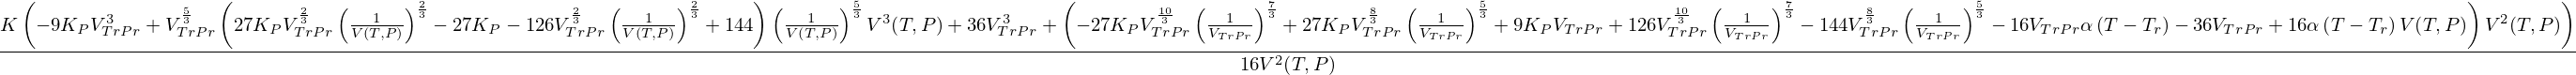

In [14]:
VTP = sym.symbols('V_TP')
A = sym.integrate((f+P).subs(V,VTP),(VTP,VTrPr,V)).simplify()
A

The Gibbs free energy contribution if given by the identity: $G = A + PV$ and ${G_{T,P}} - {G_{{T_r},{P_r}}} = {A_{T,P}} + PV - {A_{{T_r},{P_r}}} - {P_r}{V_{{T_r},{P_r}}}$

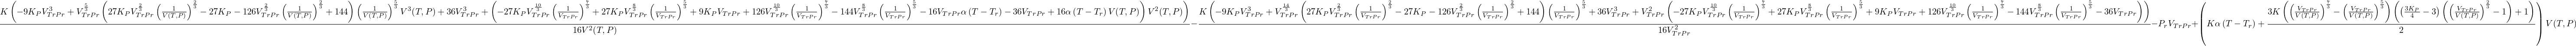

In [15]:
GTr = A+(f+P)*V-A.subs(V,VTrPr)-Pr*VTrPr
GTr

The *implicit_function* argument of the *add_expression_to_model* method conveys information about how to compute a value for the implicit variable contained in the Gibbs free energy expression passed as the first argument.  It is an array of tuples; each tuple has three components. The first is a sympy expression for the implicit function, which evaluates to zero for an internally consistent set of *T*, *P*, *V*. The second component is a symbol for the function definition of the implicit variable.  The third component is is a sympy expression that initializes *f* in the iterative routine. This expression must be defined in terms of known parameters and Tr, Pr, T, P.. 

In [16]:
model.add_expression_to_model(GTr, params, implicit_functions=[(f,V,VTrPr*.95)])

Note:  
The implicit function will be utilized in code generation not only to compute the value of *V*, given a *T* and *P*, but also to evaluate derivatives of *V*,  Since:  

$dP = {\left( {\frac{{\partial P}}{{\partial V}}} \right)_T}dV + {\left( {\frac{{\partial P}}{{\partial T}}} \right)_V}dT$,   

${d^2}P = d{\left( {\frac{{\partial P}}{{\partial V}}} \right)_T}dV + {\left( {\frac{{\partial P}}{{\partial V}}} \right)_T}{d^2}V + d{\left( {\frac{{\partial P}}{{\partial T}}} \right)_V}dT + {\left( {\frac{{\partial P}}{{\partial T}}} \right)_V}{d^2}T$, or  

${d^2}P = {\left( {\frac{{{\partial ^2}P}}{{\partial {V^2}}}} \right)_T}dVdV + 2\left( {\frac{{{\partial ^2}P}}{{\partial V\partial T}}} \right)dVdT + {\left( {\frac{{{\partial ^2}P}}{{\partial {T^2}}}} \right)_V}dTdT + {\left( {\frac{{\partial P}}{{\partial V}}} \right)_T}{d^2}V + {\left( {\frac{{\partial P}}{{\partial T}}} \right)_V}{d^2}T$